In [14]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis, pearsonr
from scipy.signal import butter, welch, filtfilt, resample
from scipy.interpolate import interp1d
import time
import nolds
import re
import copy

from PreprocessFcns import *

%matplotlib inline

#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [15]:
if platform.system() == 'Windows':
    if platform.release() == '10':
        path = r'D:\CIS-PD Study\Subjects' #Windows remote path
        folder_path = r'D:\CIS-PD Study' #generic Windows repo path
        dict_path = 'D:\CIS-PD Study\Data_dict'
        scores_path = r'D:\CIS-PD Study\Scores' #remote repo
        features_path = r'D:\CIS-PD Study\FeatureMatrix' #remote repo
        
    elif platform.release() == '7':
        path = r'X:\CIS-PD Study\Subjects'
        folder_path = r'X:\CIS-PD Study'
#         dict_path = r'C:\Users\adai\Documents\Data_dict'
        dict_path = r'X:\CIS-PD Study\Data_dict'
        scores_path = r'X:\CIS-PD Study\Scores'
        features_path = r'X:\CIS-PD Study\FeatureMatrix'
    
else:
    path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
    folder_path = '/Volumes/RTO/CIS-PD Study/'
    dict_path = '../Data_dict' # Mac local path
    scores_path = '../Scores/' # Mac local path
    features_path = '../FeatureMatrix' # Mac local path

In [16]:
def gen_unimodal_data(input_dict, side, unimodal_acts=None, shift=50):
#---------------------------------------------------------------------------------------------------------
# Reduces certain activities and subgroup of sensors in act_dict to only include data during active periods
# i.e right hand sensor excludes data when left hand is performing task (e.g. supination-pronation)
#
# Inputs: act_dict - dictionary of both MDS-UPDRS and Motor Assessment activities separated by trial, sensor location, and
#                    accelerometer + gyroscope or accelerometer + EMG/ECG data
#         unimodal_acts - list of tasks to consider for data reduction, default value is None and uses list generated within
#                         function that cycles through all unimodal tasks. Can feed list to only look at specific subset
#         shift - shifting value of starting and ending index of reduced data. Default value is 50
#
# Outputs: act_dict - returns dictionary with appropriate tasks and sensors limited in scope to active data
#---------------------------------------------------------------------------------------------------------

    output_dict = copy.deepcopy(input_dict)
    
    if unimodal_acts and unimodal_acts is not list:
        
        raise Error("unimodal_acts must be of type list")
        
    elif not unimodal_acts:
        unimodal_acts = list(['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements'])
      
    for acts in unimodal_acts:

        for trials in range(0, len(input_dict[acts].keys())):
            
            for sensors in input_dict[acts][trials].keys():
                
                for data in input_dict[acts][trials][sensors].keys():

                    index = len(input_dict[acts][trials][sensors][data]);
                    
                    if side == 'right':
                    
                        temp_data = input_dict[acts][trials][sensors][data][shift:((index//2)-shift)];
                        output_dict[acts][trials][sensors][data] = temp_data;
                    
                    elif side == 'left':
                    
                        temp_data = input_dict[acts][trials][sensors][data][((index//2)+shift):(index-shift)];
                        output_dict[acts][trials][sensors][data] = temp_data;
                    
    return output_dict

In [4]:
#save corrected version of motor scores.xls 
mot_scores = pd.read_excel(os.path.join(scores_path, 'MotorTasks.xls'))
#fix error in original cols labels
mot_scores.columns.values[75] = 'alternating left hand movements tremor right upper limb'
#remove words:(Qxx) and 'rating' from each column for readability
cols= mot_scores.columns
cols = cols.tolist()
colsnew = [x.split('(')[0] for x in cols]
colsnew = [x.strip() for x in colsnew] #remove whitspace
colsnew = [x.split('rating')[0] for x in colsnew]
colsnew = [x.strip() for x in colsnew]
colsnew = [x.lower() for x in colsnew] #make all lower case 
colsnew = [x.replace('\x97',' ') for x in colsnew]    
#simplify notation
for i in range(len(colsnew)):
    x = colsnew[i]
    if x.find('finger to nose')>-1:
        colsnew[i] = x.replace(' hand','')
    if x.find('alternating')>-1:
        colsnew[i] = x.replace(' hand movements','')
c = dict(zip(cols,colsnew))
mot_scores = mot_scores.rename(index=str, columns=c)
#change 1 month label to 4 wks for proper sorting (to incorporate in xls file)
mot_scores.loc[mot_scores['visit']=='1 Month','visit']='4 Weeks'
mot_scores.to_excel(os.path.join(scores_path, 'Scores.xls')) #note that timestamps are not properly converted

In [18]:
#aggreagate metadata and rawdata from all sensor (accel,gyro) locations
#startTS and endTS specificies fraction of raw sensors data to use to generate clips
def DataAggregator_allLocs(tasks,task_scores_all,clipsize=5000,overlap=0,locations=[],namesuffix=None,verbose=False,resample=True):

# task_scores_all=task_scores
# clipsize=5000
# overlap=0
# verbose=False

    t0=time.time()
    #load subject scores (std motor assessments)
    mot_scores = pd.read_excel(os.path.join(scores_path, 'Scores.xls'))

    #load subjects features data and assemble with scores/subj metadata
    d = os.listdir(dict_path)
    fnames = [filename for filename in d if filename.startswith('1')]
#     fnames=[fnames[0]] #test only on 1st subject (uncomment TO DEBUG)

    clip_data = pd.DataFrame() #the table with features and metadata

    #loop through subjects
    print(fnames)
    for subj_filename in fnames:

        #load current subject sensor data
        subj = int(subj_filename[:4]) #subj code
        f = open(os.path.join(dict_path,subj_filename),'rb')    
        act_dict_full = pickle.load(f)
        f.close()
        print('\nLoaded Subj %s sensor data'%subj)
            
        T = zip(tasks,task_scores_all) #make iterator

        act_dict_left = gen_unimodal_data(act_dict_full, side='left')
        act_dict_right = gen_unimodal_data(act_dict_full, side='right')

        #loop through tasks for current subject
        for task,task_scores in T: 

            print(task)
            ts = task_scores #copy variable

            for side in ['left','right']:

                if side == 'left':
                    act_dict = act_dict_left
                elif side == 'right':
                    act_dict = act_dict_right
                else:
                    act_dict = act_dict_full

                #****EXTRACT SCORES DATA FOR CURRENT TASK AND SIDE***
                #deal with exception for alternating and finger to nose (unilateral tasks)
                if (task_scores.find('alternating') > -1) | (task_scores.find('finger to nose') > -1):
                    task_scores=ts+ ' ' + side
                print('Aggregating scores for %s side'%side)
                #extract scores for corresponding task, subject and side
                subj_score = mot_scores.loc[mot_scores['subject']==subj,['subject','visit',
                                            task_scores+ ' ' + 'bradykinesia ' + side + ' upper limb',
                                            task_scores+ ' ' + 'tremor ' + side + ' upper limb',
                                            task_scores+ ' ' + 'dyskinesia ' + side + ' upper limb']]
                #rename cols
                subj_score = subj_score.rename(index=str,
                                               columns={subj_score.columns[2]:'Bradykinesia',subj_score.columns[3]:'Tremor',
                                                        subj_score.columns[4]:'Dyskinesia'})
                #reindex score table
                subj_score.index = range(len(subj_score))


    #                 print(subj_score.head())

                #Check that # of recordings and # of scored visits are equal
                Visits = act_dict[task].keys()
                n_rec = len(Visits) #of sensor recordings
                n_scores = len(subj_score)  #of visits in Database
                if n_scores != n_rec:
                    print('WARNING # of recordings does not match # of scored visits - matching first %d recs!'%min(n_scores,n_rec))
                    Visits = list(act_dict[task].keys())[0:min(n_scores,n_rec)]

                if len(subj_score) < 1:
                    print('no scores data for subject %d -- skipping..'%subj)
                    continue

                #****EXTRACT RAW CLIPS FROM ALL LOCATIONS FOR CURRENT VISIT+SIDE AND APPEND***
                for visit in Visits:
    #                 print(visit,subj_score.iloc[visit]['visit'])
    

                    clip_data_visit=pd.DataFrame() #storing all clips from current visit and side
        
                    #choose to extract from all locations or only the ones contained in locations
                    if len(locations) == 0: #all locations
                        locs = act_dict[task][visit].keys()
                        locs = [i for i in locs if (i.find(side)>0)] #choose senors on current side
                        locs.append('sacrum'); locs.append('medial_chest')
                    else: #selected locations 
                        locs = [i+side for i in locations if (i != 'sacrum') & (i != 'medial_chest')] #choose senors on current side 
                        if 'sacrum' in locations:
                            locs.append('sacrum')
                        if 'medial_chest' in locations:
                            locs.append('medial_chest')
                        
                    for location in locs:
                        
                        for s in ['accel','gyro']:
                            
                            if verbose:
                                print(task,' sensortype = %s - visit %d'%(s,visit))
                            #create clips and store in a list
                            rawdata = act_dict[task][visit][location][s].copy()

                            if rawdata.empty is True: #skip if no data for current sensor
                                continue
                                
                            #by default filters accelerometer data only
                            #HP filter 0.5Hz (remove gravity)
#                             filterdata(act_dict,task,location,visit)
                            #Lowpass filter (Bradykinesia)
#                                 filterdata(act_dict,task,location,visit,ftype='lowpass',cutoff=3)                                
                            #BPass filter (Tremor)
#                                 filterdata(act_dict,task,location,visit,ftype='bandpass',cutoff_bp=[3,8])

                            rawdata = act_dict[task][visit][location][s].copy()
                            #reindex time (relative to start)
                            idx = rawdata.index
                            idx = idx-idx[0]
                            rawdata.index = idx
                            #create clips data
                            deltat = np.median(np.diff(rawdata.index))
                            clips = pd.DataFrame()  
                            #take clips
                            
                            if location.find(side)>-1:
                                location_name = re.sub(side, '', location) #column name dataframe (remove side info)
                            else:
                                location_name = location
                                
                            idx = np.arange(0,rawdata.index[-1],clipsize*(1-overlap))
                            for i in idx:
                                c = (rawdata[(rawdata.index>=i) & (rawdata.index<i+clipsize)]).copy()
                                #add time information to clips [seconds]
                                c['Time']=(c.index.values/1000)-(c.index.values/1000)[0]
                                
                                #resample to equal number of samples (313)
                                if resample:
                                    numsamples = int(np.ceil(62.5*clipsize/1000)) #number of new samples
                                    #resample if clip has enough samples
                                    if  (( (location_name != 'medial_chest') | (location_name[:-1] != 'flexor_digitorum') ) & (len(c) > 290))  | (((location_name == 'medial_chest') | (location_name[:-1] == 'flexor_digitorum')) & (len(c) > 144)):

                                        datares = np.empty((numsamples,4))
                                        t = c['Time'].values #time vector
                                        tnew = np.linspace(0,t[-1],numsamples) #!assume end of clip coincides with clip length (5 secs)
                                        datares[:,-1] = tnew
                                        for a in range(3):
                                            f=interp1d(t,c.iloc[:,a],kind='linear')
                                            datares[:,a] = f(tnew)
                                    else:
#                                         print('%s %s,nan inserted'%(location_name,len(c)))
                                        datares = np.nan*np.empty(1)
#                                         datares = np.array([]) #discard clip (empty array)
                                        
                                            
                                    df = pd.DataFrame({location_name+'_'+s:[datares]},index=[visit])

                                else: #do not resample
                                    df = pd.DataFrame({location_name+'_'+s:[c.values]},index=[visit])
                                
                                clips=pd.concat((clips,df)) #concatenate clips from current visit

                            nc = len(clips)
                            if (nc < clip_data_visit.shape[0]) & (clip_data_visit.empty is False):
                                print(visit,location+s,len(clips))
                                nd = clip_data_visit.shape[0]-nc
                                print('current sensor has less clips - adding %d empties'%nd)
                                clips=pd.concat((clips,pd.DataFrame({location_name+'_'+s:np.nan*np.empty(nd)},
                                                                    index=[np.ones(nd)*visit])))
                            if (nc > clip_data_visit.shape[0]) & (clip_data_visit.empty is False):
                                print(visit,location+s,len(clips))
                                nd = nc-clip_data_visit.shape[0]
                                print('current sensor has more clips - discarding last %d clips'%nd)
                                clips = clips.iloc[:-nd]

                            clips.reset_index(inplace=True, drop=True)  # temp fix unique indexing bug from gen_unimodal_data
                                                                        # will look into, added 3/19/2018

                            clip_data_visit=pd.concat((clip_data_visit,clips),axis=1) #concatenate clips across locations

                    #concatenates metadata to all clips for current visit
                    clip_data_visit['Subject']=subj
                    clip_data_visit['Task']=task
                    clip_data_visit['Side']=side
                    clip_data_visit['Visit']=subj_score.iloc[visit]['visit']
                    #scores
                    clip_data_visit['Bradykinesia'] = subj_score['Bradykinesia'][visit]
                    clip_data_visit['Tremor'] = subj_score['Tremor'][visit]
                    clip_data_visit['Dyskinesia'] = subj_score['Dyskinesia'][visit]

                    clip_data = pd.concat((clip_data,clip_data_visit)) #concatenate clips across visits (index) 


    #SAVING DATA 
    metadata = ['Subject','Visit','Side','Task','Tremor','Bradykinesia','Dyskinesia']
    cols = clip_data.columns.tolist()
    cols = np.setdiff1d(cols,metadata).tolist()
    clip_data = clip_data[metadata+cols]
    # clip_data = clip_data[cols]
    # clip_data = clip_data[metadata+list(clip_data.columns[:10].values)]    
    print('\nClip Data matrix generated')
    print(clip_data.shape)

    if namesuffix == None:
        namesuffix=''
    #save as hdf5 (not suitable for large dataframes)
#     saved_filename = 'DataRaw_AllLocs'+namesuffix+'.hdf5'
#     clip_data.to_hdf(os.path.join(features_path,saved_filename),'w')
    
    #save data as dictionary pickle
    clip_data=clip_data.reset_index() #to save dictionary with proper indices
    clip_dict = clip_data.to_dict()    
    saved_filename = 'DataRaw_AllLocs'+namesuffix+'.pkl'
    f = open(os.path.join(features_path,saved_filename),'wb')
    pickle.dump(clip_dict,f)
    f.close()
    
    print('Data matrix saved in ' + str(os.path.join(features_path,saved_filename)))
    t = time.time()
    eltime = (t-t0)/60
    print('Elapsed time = %.2f min'%eltime)

    return clip_data,clip_dict


In [20]:
tasks = ['Motor #2: Walking','Motor #3: Walking while Counting','Motor #4: Finger to Nose',
         'Motor #5: Alternating Hand Movements','Motor #6: Sit to Stand','Motor #7: Drawing on Paper',
         'Motor #8: Typing on a Computer','Motor #9: Nuts and Bolts','Motor #10: Drinking Water',
         'Motor #11: Organizing Folder','Motor #12: Folding Towels','Motor #1: Standing','Motor #13: Sitting']

task_scores = ['walking','walking while counting','finger to nose','alternating','sit to stand','drawing on a paper',
               'typing on a computer keyboard','assembling nuts and bolts','taking a glass of water and drinking',
               'organizing sheets in a folder','folding towels','standing','sitting'] #name of task in scores sheet

locs = ['dorsal_hand_','anterior_thigh_','sacrum'] #sensor location

In [50]:
tasks = ['Motor #4: Finger to Nose']
task_scores = ['finger to nose']
locs =[] #to generate clips from all locations

In [21]:
data = DataAggregator_allLocs(tasks,task_scores,locations=locs,overlap=0.5,namesuffix='Unfiltered')

['1004dict.pkl', '1016dict.pkl', '1018dict.pkl', '1019dict.pkl', '1020dict.pkl', '1024dict.pkl', '1029dict.pkl', '1030dict.pkl', '1032dict.pkl', '1038dict.pkl', '1044dict.pkl', '1046dict.pkl', '1047dict.pkl', '1049dict.pkl', '1051dict.pkl', '1052dict.pkl', '1053dict.pkl', '1054dict.pkl', '1055dict.pkl', '1056dict.pkl']

Loaded Subj 1004 sensor data
Motor #2: Walking
Aggregating scores for left side
Aggregating scores for right side
Motor #3: Walking while Counting
Aggregating scores for left side


KeyboardInterrupt: 

In [9]:
len(data)

48579

In [ ]:
# for loading dict, converting to df with metadata
# f = open('../FeatureMatrix/DataRaw_AllLocsResample.pkl','rb')
# data2 = pickle.load(f)
# f.close()
# metadata = ['index','Subject','Visit','Side','Task','Tremor','Bradykinesia','Dyskinesia']
# cols = data2.columns.tolist()
# cols = np.setdiff1d(cols,metadata).tolist()
# data2 = data2[metadata+cols]

In [10]:
data = pd.read_pickle(os.path.join(features_path,'DataRaw_AllLocsResample.pkl'))

In [11]:
data.head()

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,anterior_thigh__accel,anterior_thigh__gyro,dorsal_hand__accel,dorsal_hand__gyro,sacrum_accel,sacrum_gyro
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[[0.015140164229147435, 0.09125127414187245, 0...","[[78.5229266803999, -34.94316014343485, -75.77...","[[-0.015859067050104605, -0.031970438023114146...","[[2.410925459678083, 28.71747920958251, 1.8005...","[[0.007898593153291361, 0.00678187379336016, -...","[[-7.660028992141633, -6.195162890058782, 2.47..."
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[[-0.3806930569670697, 0.6838462262489783, 0.1...","[[-121.79751277943092, -0.6408789196611906, -1...","[[-0.06425506990178886, -0.07859306651980949, ...","[[-54.41367208361953, 12.970168612191856, 110....","[[0.05902357568430044, 0.2458570946481517, 0.1...","[[-5.645838101777599, 17.975127794308268, 9.36..."
2,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[[-0.2732291564669609, 0.6298778421184241, -0....","[[458.8998245212483, -81.57473105973895, -65.3...","[[0.2325753850152822, 0.13933967039797374, 0.1...","[[-45.25825894560171, 7.660028992141633, 38.78...","[[0.03456002988070333, 0.07714713579397142, 0....","[[-2.4719615472647547, 31.219958800640825, -18..."
3,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[[0.01841745040861887, 0.1155331246873035, -0....","[[-37.2625314717327, 6.256198977645455, 16.388...","[[0.03136723829891441, -0.0505767582769632, 0....","[[-10.711833371480909, -65.64431219958806, 15....","[[0.025640670942468885, 0.05803182937743645, 0...","[[-2.777141985198796, 66.25467307545614, 25.72..."
4,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[[0.18770204609670904, -0.02498542395414173, 0...","[[86.39658197909512, -15.533684290836847, 109....","[[0.03801377922804165, 0.03617817081373831, -0...","[[62.34836346990142, 23.95666437781324, -94.88...","[[0.07941650588237587, -0.3029917175421306, -0...","[[-5.3406576638437855, 4.6692607003890325, 21...."


In [12]:
data.anterior_thigh__accel.iloc[0].shape

(313, 4)

In [13]:
len(data)

48579

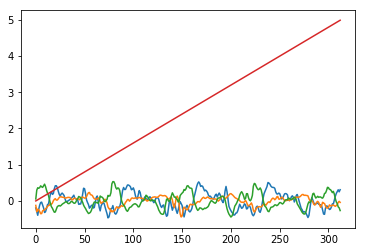

In [38]:
plt.plot(data.dorsal_hand__accel.iloc[4])

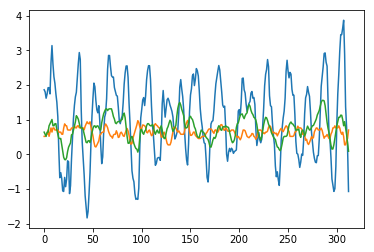

In [39]:
plt.plot(data.anterior_thigh__gyro.iloc[4][:,:-1])

In [ ]:
#remove rows where some sensors have empty clips
for s in data.columns[7:].values:
    print(s,sum(data[s].apply(type) == float))
    indempty = data[s].apply(type) == float
    data = data[~indempty]
    
print(len(data))

In [11]:
print(len(data))
for s in data.columns[7:].values:
    print(s)
    print(data[s].apply(len).unique()) #sanity check

anterior_thigh__accel 0
anterior_thigh__gyro 0
dorsal_hand__accel 0
dorsal_hand__gyro 0
sacrum_accel 0
sacrum_gyro 0
1224


## Compute Features on multiple sensors

In [ ]:
# load data and reconvert from dict to dataframe with metadata
f = open(os.path.join(features_path,'DataRaw_AllLocsHP.pkl'),'rb')
data = pickle.load(f)
f.close()
metadata = ['index','Subject','Visit','Side','Task','Tremor','Bradykinesia','Dyskinesia']
cols = data.columns.tolist()
cols = np.setdiff1d(cols,metadata).tolist()
data = data[metadata+cols]

# f = open('../FeatureMatrix/DataRaw_AllLocsResample.pkl','rb')
# data2 = pickle.load(f)
# f.close()
# metadata = ['index','Subject','Visit','Side','Task','Tremor','Bradykinesia','Dyskinesia']
# cols = data2.columns.tolist()
# cols = np.setdiff1d(cols,metadata).tolist()
# data2 = data2[metadata+cols]

In [13]:
#rawdata is a numpy array
def feature_extraction_array(rawdata):

    if np.size(rawdata) == 1:
#         print('empty')
        return np.empty([])
    
    time = rawdata[:,-1]
    Fs = np.mean(1/(np.diff(time))) #mean sampling rate in clip

    #remove time column 
    if rawdata.shape[1] > 3:
        rawdata = rawdata[:,:-1] 
        
    #Root mean square of signal on each axis
    N = np.shape(rawdata)[0]
    RMS = 1/N*np.sqrt(np.asarray(np.sum(rawdata**2,axis=0)))

    #range on each axis
    min_xyz = np.min(rawdata,axis=0)
    max_xyz = np.max(rawdata,axis=0)
    r = np.asarray(max_xyz-min_xyz)

    #Moments on each axis
    mean = np.asarray(np.mean(rawdata,axis=0))
    var = np.asarray(np.std(rawdata,axis=0))
    sk = skew(rawdata)
    kurt = kurtosis(rawdata)

    #Cross-correlation between axes pairs
    xcorr_xy = np.correlate(rawdata[:,0],rawdata[:,1],mode='same')
    # xcorr_xy = xcorr_xy/np.abs(np.sum(xcorr_xy)) #normalize values
    xcorr_peak_xy = np.max(xcorr_xy)
    xcorr_lag_xy = (np.argmax(xcorr_xy))/np.shape(xcorr_xy)[0] #normalized lag

    xcorr_xz = np.correlate(rawdata[:,0],rawdata[:,2],mode='same')
    # xcorr_xz = xcorr_xz/np.abs(np.sum(xcorr_xz)) #normalize values
    xcorr_peak_xz = np.max(xcorr_xz)
    xcorr_lag_xz = (np.argmax(xcorr_xz))/np.shape(xcorr_xz)[0]

    xcorr_yz = np.correlate(rawdata[:,1],rawdata[:,2],mode='same')
    # xcorr_yz = xcorr_yz/np.abs(np.sum(xcorr_yz)) #normalize values
    xcorr_peak_yz = np.max(xcorr_yz)
    xcorr_lag_yz = (np.argmax(xcorr_yz))/np.shape(xcorr_yz)[0]

    #pack xcorr features
    xcorr_peak = np.array([xcorr_peak_xy,xcorr_peak_xz,xcorr_peak_yz])
    xcorr_lag = np.array([xcorr_lag_xy,xcorr_lag_xz,xcorr_lag_yz])

    #Dominant freq and relative magnitude (on acc magnitude)
    xnorm = np.linalg.norm(rawdata,axis=1)
    n = np.shape(xnorm)[0] #number of samples in clip
    f,Pxx = welch(xnorm,Fs,nperseg=min(256,n))
    Pxx=Pxx[(f > 0) & (f <= 10)] #frequency range between 0 and 10 Hz
    domfreq = f[Pxx.argmax()].reshape(-1)
    Pdom_rel = (max(Pxx)/np.sum(Pxx)).reshape(-1) #power at dominant freq rel to total

    #moments of PSD
    Pxx_moments = np.array([np.nanmean(Pxx),np.nanstd(Pxx),skew(Pxx),kurtosis(Pxx)])

    #moments of jerk magnitude
    jerk = np.diff(xnorm)
    jerk_moments = np.array([np.nanmean(jerk),np.nanstd(jerk),skew(jerk[~np.isnan(jerk)]),kurtosis(jerk[~np.isnan(jerk)])])

    #sample entropy raw data (magnitude) and FFT
    sH_raw = []; sH_fft = []

    for a in range(3):
        x = rawdata[:,a]
        n = np.shape(x)[0] #number of samples in clip
        sH_raw.append(nolds.sampen(x)) #samp entr raw data
        #for now disable SH on fft
        # f,Pxx_den = welch(x,Fs,nperseg=min(256,n/4))
        # sH_fft.append(nolds.sampen(Pxx_den)) #samp entr fft
    sH_raw=np.asarray(sH_raw)
    
    #Assemble features in array
    X = np.concatenate((RMS,r,mean,var,sk,kurt,xcorr_peak,xcorr_lag,domfreq,Pdom_rel,Pxx_moments,jerk_moments,sH_raw))
    return X

In [14]:
# #test on 1 row
# x = data.anterior_thigh__accel.iloc[0]
# F = feature_extraction_array(x)
# print(F.shape)

(37,)


In [73]:
#compute features only on hand acc and gyro
t1 = time.time()
F = data.iloc[:,9:11].applymap(feature_extraction_array)
print((time.time()-t1)/60)

9.002225053310394


In [74]:
F.apply(len)

dorsal_hand__accel    4320
dorsal_hand__gyro     4320
dtype: int64

In [75]:
dataF = data.iloc[:,:7]
dataF=pd.concat((dataF,F),axis=1)

In [76]:
dataF.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,dorsal_hand__accel,dorsal_hand__gyro
0,1004,2 Weeks: Time 0,left,Motor #4: Finger to Nose,1.0,1.0,0.0,"[0.0111451202246, 0.0129562059727, 0.013638602...","[5.01652047541, 8.45564189278, 3.55284750763, ..."
1,1004,2 Weeks: Time 0,left,Motor #4: Finger to Nose,1.0,1.0,0.0,"[0.0101368337193, 0.00980851677036, 0.01192579...","[3.28336373051, 11.7446881916, 3.68519049331, ..."


In [77]:
dataF.to_hdf('../FeatureMatrix/Features_HP+LP.h5','w')

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['Visit', 'Side', 'Task', 'dorsal_hand__accel', 'dorsal_hand__gyro']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [15]:
#test on 100 rows
t1 = time.time()
F = data.iloc[:100,7:].applymap(feature_extraction_array)
print((time.time()-t1)/60)

empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
0.5310867150624593


In [16]:
F.apply(len)

anterior_thigh__accel    100
anterior_thigh__gyro     100
dorsal_hand__accel       100
dorsal_hand__gyro        100
sacrum_accel             100
sacrum_gyro              100
dtype: int64

In [17]:
F.head()

,anterior_thigh__accel,anterior_thigh__gyro,dorsal_hand__accel,dorsal_hand__gyro,sacrum_accel,sacrum_gyro
0,"[0.0190065256974, 0.0392332703719, 0.022744978...","[10.2735064283, 2.70628321634, 5.06156027666, ...","[0.00864849467653, 0.0109489753008, 0.00729320...","[2.76357718659, 1.92269058745, 4.20092382287, ...","[0.00526835057686, 0.0119961084358, 0.00705591...","[0.821561465605, 1.12651785292, 0.664853976891..."
1,"[0.0149832300964, 0.0342450895391, 0.016847710...","[9.00806781087, 2.191344381, 4.14873090415, 13...","[0.007308936014, 0.00999890421054, 0.005955145...","[2.6885012577, 2.87449818754, 4.43727495635, 2...","[0.00560763652441, 0.00985573688914, 0.0061202...","[0.705814899314, 3.47252797918, 0.743363474454..."
2,"[0.0180417583751, 0.0404949369895, 0.021012452...","[9.57420548284, 2.41849860453, 5.09429658375, ...","[0.00789533806077, 0.0102285568271, 0.00862667...","[3.26187420639, 2.94128163697, 4.68921869519, ...","[0.00640904323001, 0.0121600018656, 0.00671856...","[0.827483443807, 2.65230166411, 0.864615727337..."
3,"[0.0205105367974, 0.0415885417297, 0.023263090...","[10.7951006304, 3.06603190743, 5.37095998162, ...","[0.00858875387415, 0.0122192149539, 0.00688990...","[2.77810907781, 2.31555905589, 4.96053014631, ...","[0.00605284836418, 0.0140876462334, 0.00754228...","[0.825750092007, 2.28549990288, 0.829151685578..."
4,"[0.0195279524902, 0.0377563093994, 0.021351920...","[9.59769867838, 2.49859289183, 4.61524565683, ...","[0.00887350847284, 0.0105458055384, 0.00604401...","[2.82170510505, 3.09674298953, 5.07018285471, ...","[0.00618242353299, 0.0117429551314, 0.00659903...","[0.752788915681, 3.66242572682, 0.87323241417,..."


In [17]:
data.Task.unique()

array(['Motor #2: Walking', 'Motor #3: Walking while Counting',
       'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
       'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
       'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
       'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
       'Motor #12: Folding Towels', 'Motor #1: Standing',
       'Motor #13: Sitting'], dtype=object)